In [191]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [192]:
import numpy as np
import pandas as pd

In [193]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [194]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [195]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [196]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

# reflect the tables

In [197]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [198]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [199]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [200]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
session.query(Measurement.date).order_by(Measurement.date.desc()).limit(1).all()
# one year from this is 2016-08-23

[('2017-08-23')]

In [201]:
# Perform a query to retrieve the data and precipitation scores
# 2016-08-22 to include the 23rd
stmt = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > '2016-08-22').\
    order_by(Measurement.date.asc()).statement

In [202]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.read_sql_query(stmt, session.bind)
df.head()

,date,prcp
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02


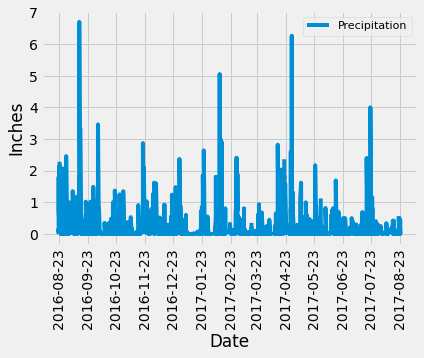

In [204]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(df.date, df.prcp)
plt.xticks(['2016-08-23', '2016-09-23', '2016-10-23', '2016-11-23', '2016-12-23', '2017-01-23', '2017-02-23', '2017-03-23', '2017-04-23', '2017-05-23', '2017-06-23', '2017-07-23', '2017-08-23',])
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.legend(labels=["Precipitation"], loc="upper right", prop={"size":11})
plt.show()

In [205]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [206]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [220]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
    filter(Measurement.date > '2016-08-22').\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519397', 361),
 ('USC00519281', 352),
 ('USC00516128', 349),
 ('USC00513117', 343),
 ('USC00519523', 337),
 ('USC00514830', 305),
 ('USC00517948', 183)]

In [221]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519397').filter(Measurement.date > '2016-08-22').all()

[('USC00519397', 60.0, 87.0, 75.21052631578948)]

In [222]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_stmt = session.query(Measurement.station, Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').filter(Measurement.date > '2016-08-22').statement

In [223]:
tobs_df = pd.read_sql_query(tobs_stmt, session.bind)
tobs_df.head()

,station,tobs
0,USC00519281,77.0
1,USC00519281,77.0
2,USC00519281,80.0
3,USC00519281,80.0
4,USC00519281,75.0


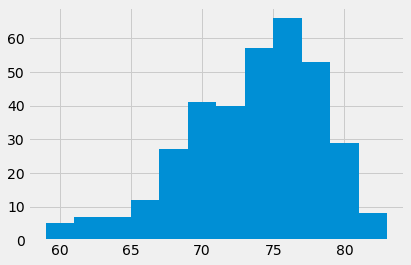

In [224]:
plt.hist(tobs_df["tobs"], bins=12)
plt.show()

## Bonus Challenge Assignment

In [212]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [250]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# plan is 7/2/16 to 13/2/16, so
print(calc_temps('2015-02-07', '2015-02-13'))

[(60.0, 69.0204081632653, 79.0)]


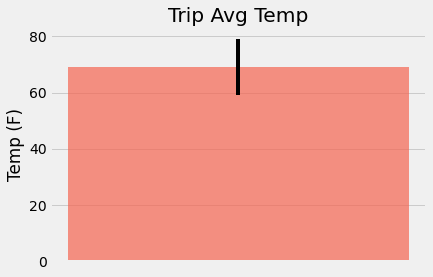

In [251]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
temps = calc_temps('2015-02-07', '2015-02-13')
plt.bar(1, temps[0][1], alpha=0.7, color="#F56551")
plt.errorbar(1, temps[0][1], yerr=[temps[0][2] - temps[0][1]], ecolor="black")
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.xticks([])
plt.show()


In [255]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
    filter(Station.station == Measurement.station).\
    filter(Measurement.date >= '2015-02-07').filter(Measurement.date <= '2015-02-13').\
    group_by(Station.station).order_by(func.sum(Measurement.prcp).desc()).all()


[('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.24),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.15),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.1),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.1),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.1),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  0.08),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.02),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.0)]